In [1]:
# imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import geodatasets
from pathlib import Path
from matplotlib import font_manager
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import FuncFormatter
from IPython.display import HTML
import matplotlib.cm as cm
from matplotlib import colormaps
import json
from matplotlib.colors import LinearSegmentedColormap
import random

# data folder
data_folder = '../01_data/'
figure_folder = '../03_documents/02_supplement_figures/'

# input data
annual_metrics = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')

# 01 - Interactive HTML Plot

In [12]:
# your palette
migration_colors = [
    '#fdd070', '#fdae61', '#f98e52', '#f46d43', '#e34a33', '#d73027',
    '#c51b7d', '#ae017e', '#8c0273', '#5f0165', '#2b0040'
]

# convert hex to rgb (0–1 floats)
migration_rgb = [mcolors.to_rgb(c) for c in migration_colors]

# output html location
output_html = Path("../docs/interactive_population_animation.html")

# prep data
country_data_dict = {}
countries = sorted(annual_metrics['Country'].dropna().unique())

for country in countries:
    df_country = (
        annual_metrics[annual_metrics['Country'] == country]
        .copy()
        .sort_values("year")
    )
    df_country = df_country[df_country['total_pop'] > 0]

    years = df_country['year'].astype(int).unique().tolist()
    locations = df_country['ID_UC_G0'].astype(str).unique()

    # assign random palette color to each location
    color_map = {
        loc: [float(c) for c in random.choice(migration_rgb)]
        for loc in locations
    }

    records = []
    for _, row in df_country.iterrows():
        records.append({
            "year": int(row["year"]),
            "ID_UC_G0": str(row["ID_UC_G0"]),
            "total_pop": float(row["total_pop"]),
            "total_dr": float(row["total_dr"]),
            "Name": row["Name"]
        })

    country_data_dict[country] = {
        "years": years,
        "data": records,
        "color_map": color_map
    }

country_data_json = json.dumps(country_data_dict)

In [18]:
html = f"""
<!DOCTYPE html>
<html>
<head>
<meta charset="utf-8">
<style>
body {{ font-family: "DejaVu Sans Mono", monospace; }}
button {{ font-family: "DejaVu Sans Mono", monospace; }}
</style>
</head>
<body>

<h2>Global Urban Demographic Dataset (GUDD)</h2>
<h2>Population vs Dependency Ratio</h2>

Country:
<select id="dropdown"></select>
&nbsp;&nbsp;
<button onclick="play()">Play</button>
<button onclick="pause()">Pause</button>
<button onclick="faster()">+</button>
<button onclick="slower()">-</button>
<br><br>

<canvas id="canvas" width="900" height="650" style="border:1px solid black"></canvas>

<script>
const FONT = "14px 'DejaVu Sans Mono', monospace";
const TITLE_FONT = "20px 'DejaVu Sans Mono', monospace";
const xTicks = [100,1000,10000,100000,1000000,10000000,100000000,1000000000];
const countryData = {country_data_json};

const canvas = document.getElementById("canvas");
const ctx = canvas.getContext("2d");
const dropdown = document.getElementById("dropdown");

Object.keys(countryData).forEach(c => {{
    let opt = document.createElement("option");
    opt.value = c;
    opt.text = c;
    dropdown.appendChild(opt);
}});

let country = dropdown.value;
let frame = 0;
let speed = 300;
let running = true;
let lastTime = 0;
let hover = {{x:0, y:0, text:"", active:false}};
let mouseX = 0, mouseY = 0;

canvas.addEventListener("mousemove", evt => {{
    const rect = canvas.getBoundingClientRect();
    mouseX = evt.clientX - rect.left;
    mouseY = evt.clientY - rect.top;
}});

function play() {{ running=true; }}
function pause() {{ running=false; }}
function faster() {{ speed=Math.max(50,speed-50); }}
function slower() {{ speed+=50; }}

function humanFormat(x){{
    if(x>=1e9) return "1B";
    if(x>=1e6) return (x/1e6)+"M";
    if(x>=1e3) return (x/1e3)+"K";
    return x;
}}

if (!CanvasRenderingContext2D.prototype.roundRect) {{
    CanvasRenderingContext2D.prototype.roundRect = function(x,y,w,h,r){{
        if(r===undefined) r=5;
        this.beginPath();
        this.moveTo(x+r,y);
        this.lineTo(x+w-r,y);
        this.quadraticCurveTo(x+w,y,x+w,y+r);
        this.lineTo(x+w,y+h-r);
        this.quadraticCurveTo(x+w,y+h,x+w-r,y+h);
        this.lineTo(x+r,y+h);
        this.quadraticCurveTo(x,y+h,x,y+h-r);
        this.lineTo(x,y+r);
        this.quadraticCurveTo(x,y,x+r,y);
        this.closePath();
    }};
}}

function drawAxes(xMin,xMax,yMin,yMax,padding){{
    ctx.font = FONT;
    ctx.fillStyle = "black";
    ctx.strokeStyle = "black";

    ctx.beginPath();
    ctx.moveTo(padding,padding);
    ctx.lineTo(padding,600-padding);
    ctx.lineTo(900-padding,600-padding);
    ctx.stroke();

    ctx.strokeStyle="rgba(0,0,0,0.1)";
    ctx.textAlign="right";
    ctx.textBaseline="middle";

    let yStep = (yMax - yMin) / 10;
    for(let y=yMin; y<=yMax+0.0001; y+=yStep){{
        let py = 600-padding-(y-yMin)/(yMax-yMin)*(600-2*padding);
        ctx.beginPath();
        ctx.moveTo(padding,py);
        ctx.lineTo(900-padding,py);
        ctx.stroke();
        ctx.fillStyle="black";
        ctx.fillText(y.toFixed(2), padding-5, py);
    }}

    ctx.strokeStyle="black";
    ctx.lineWidth=0.6;

    let logMin = Math.floor(Math.log10(xMin));
    let logMax = Math.ceil(Math.log10(xMax));
    for(let decade=logMin; decade<=logMax; decade++){{
        let base = Math.pow(10,decade);
        for(let i=2;i<10;i++){{
            let val = base*i;
            if(val<xMin || val>xMax) continue;
            let px = padding+(Math.log10(val)-Math.log10(xMin))/(Math.log10(xMax)-Math.log10(xMin))*(900-2*padding);
            ctx.beginPath();
            ctx.moveTo(px,600-padding);
            ctx.lineTo(px,600-padding+6);
            ctx.stroke();
        }}
    }}

    ctx.lineWidth=1;
    xTicks.forEach(val => {{
        if(val<xMin||val>xMax) return;
        let px = padding+(Math.log10(val)-Math.log10(xMin))/(Math.log10(xMax)-Math.log10(xMin))*(900-2*padding);
        ctx.strokeStyle="rgba(128,128,128,0.2)";
        ctx.setLineDash([4,4]);
        ctx.beginPath();
        ctx.moveTo(px,padding);
        ctx.lineTo(px,600-padding);
        ctx.stroke();
        ctx.setLineDash([]);
        ctx.strokeStyle="black";
        ctx.beginPath();
        ctx.moveTo(px,600-padding);
        ctx.lineTo(px,600-padding+10);
        ctx.stroke();
        ctx.fillStyle="black";
        ctx.textAlign="center";
        ctx.textBaseline="top";
        ctx.fillText(humanFormat(val),px,600-padding+12);
    }});

    ctx.save();
    ctx.translate(25,300);
    ctx.rotate(-Math.PI/2);
    ctx.fillText("Total Dependency Ratio",0,0);
    ctx.restore();
    ctx.fillText("Total Population",450,590);
}}

function draw(timestamp){{
    requestAnimationFrame(draw);
    if(running && timestamp-lastTime<speed) return;
    if(running) lastTime=timestamp;

    ctx.clearRect(0,0,900,600);
    const padding=80;
    const data=countryData[country].data;
    const years=countryData[country].years;
    const colorMap=countryData[country].color_map;
    const year=years[frame%years.length];
    const pops=data.map(d=>d.total_pop);
    const drs=data.map(d=>d.total_dr);
    const xMin=Math.min(...pops)*0.9;
    const xMax=Math.max(...pops)*1.1;
    const yMinRaw=Math.min(...drs);
    const yMaxRaw=Math.max(...drs);
    const yPad=(yMaxRaw-yMinRaw)*0.05;
    const yMin=yMinRaw-yPad;
    const yMax=yMaxRaw+yPad;

    drawAxes(xMin,xMax,yMin,yMax,padding);
    hover.active=false;

    data.forEach(d => {{
        if(d.year>year) return;
        const x = padding+(Math.log10(d.total_pop)-Math.log10(xMin))/(Math.log10(xMax)-Math.log10(xMin))*(900-2*padding);
        const y = 600-padding-(d.total_dr-yMin)/(yMax-yMin)*(600-2*padding);
        const color = colorMap[d.ID_UC_G0];
        const isCurrent = d.year==year;
        const radius = isCurrent ? Math.sqrt(100/Math.PI) : Math.sqrt(10/Math.PI);
        const alpha = isCurrent ? 1 : 0.3;

        ctx.beginPath();
        ctx.fillStyle=`rgba(${{Math.floor(color[0]*255)}},${{Math.floor(color[1]*255)}},${{Math.floor(color[2]*255)}},${{alpha}})`;
        ctx.arc(x,y,radius,0,2*Math.PI);
        ctx.fill();
        ctx.lineWidth=0.8;
        ctx.strokeStyle="black";
        ctx.stroke();

        if(Math.hypot(mouseX-x, mouseY-y)<radius){{
            hover.active=true;
            hover.x=x;
            hover.y=y;
            hover.text=d.Name;
        }}
    }});

    if(hover.active){{
        ctx.font=FONT;
        const paddingBox=12;  // widened hover box
        const textWidth=ctx.measureText(hover.text).width;
        const textHeight=20;
        const boxX=hover.x-textWidth/2-paddingBox;
        const boxY=hover.y-textHeight/2-paddingBox;
        const boxW=textWidth+2*paddingBox;
        const boxH=textHeight+2*paddingBox;

        ctx.fillStyle="lightgray";
        ctx.strokeStyle="black";
        ctx.roundRect(boxX,boxY,boxW,boxH,4);
        ctx.fill();
        ctx.stroke();

        ctx.fillStyle="black";
        ctx.textAlign="center";
        ctx.textBaseline="middle";
        ctx.fillText(hover.text,hover.x,hover.y);
    }}

    ctx.font=TITLE_FONT;
    ctx.fillStyle="black";
    ctx.textAlign="center";
    ctx.fillText("Urban Population Dependency Ratio",450,30);
    ctx.fillText(country + " — " + year,450,60);

    if(running) frame++;
}}

dropdown.onchange = function(){{country=dropdown.value; frame=0;}};
requestAnimationFrame(draw);
</script>

</body>
</html>
"""

output_html.write_text(html)
print("Saved:", output_html)

Saved: ../docs/interactive_population_animation.html


# 02 - Single GIF for a given country

Saved GIF: ../03_documents/03_other_figures/Ghana_population_dependency_ratio.gif


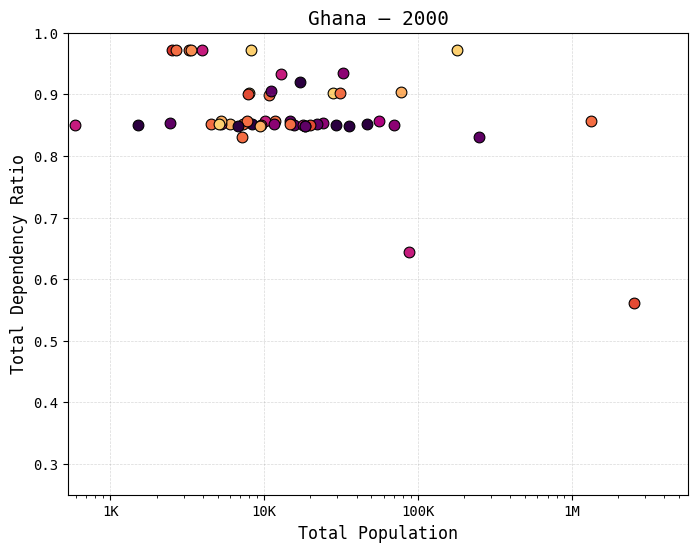

In [19]:
###########
country_to_plot = "Ghana"
###########

output_folder = Path("../03_documents/03_other_figures/")
output_folder.mkdir(parents=True, exist_ok=True)
output_gif = output_folder / f"{country_to_plot}_population_dependency_ratio.gif"

# NEW COLORS — migration palette
migration_colors = [
    '#fdd070', '#fdae61', '#f98e52', '#f46d43', '#e34a33', '#d73027',
    '#c51b7d', '#ae017e', '#8c0273', '#5f0165', '#2b0040'
]

# convert to matplotlib format
migration_rgb = [mcolors.to_rgb(c) for c in migration_colors]

# set font
mono_font = font_manager.FontProperties(family="DejaVu Sans Mono")

# load data
annual_metrics = pd.read_csv(Path(data_folder) / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')
df_country = annual_metrics[annual_metrics["Country"] == country_to_plot].copy()
df_country = df_country[df_country["total_pop"] > 0].sort_values("year")
years = sorted(df_country["year"].unique())
locations = sorted(df_country["ID_UC_G0"].unique())

pop_min = df_country["total_pop"].min()
pop_max = df_country["total_pop"].max()

# assign random migration palette color to each location
color_map = {loc: migration_rgb[random.randint(0, len(migration_rgb)-1)]for loc in locations}

# human readable pop formatter
def human_format(x, pos):

    if x >= 1e9: return f"{int(x/1e9)}B"
    if x >= 1e6: return f"{int(x/1e6)}M"
    if x >= 1e3: return f"{int(x/1e3)}K"
    return str(int(x))
formatter = FuncFormatter(human_format)

# create figure
fig, ax = plt.subplots(figsize=(8,6))

# update function
def update(frame):

    year = years[frame]
    ax.clear()
    past = df_country[df_country["year"] <= year]
    current = df_country[df_country["year"] == year]
    ax.set_xscale("log")
    ax.set_xlim(pop_min*0.9, pop_max*1.1)
    ax.set_ylim(0.25, 1)
    ax.set_xlabel("Total Population", fontproperties=mono_font, fontsize=12)
    ax.set_ylabel("Total Dependency Ratio", fontproperties=mono_font, fontsize=12)
    ax.set_title(f"{country_to_plot} — {year}", fontproperties=mono_font, fontsize=14)
    ax.xaxis.set_major_formatter(formatter)
    ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(10)
    # trails
    for loc in locations:
        loc_data = past[past["ID_UC_G0"] == loc]
        if len(loc_data) > 1:
            trail = loc_data.iloc[:-1]
            ax.scatter(
                trail["total_pop"],
                trail["total_dr"],
                s=12,
                color=color_map[loc],
                alpha=0.25,
                edgecolor="black",
                linewidth=0.3
            )

    # current points
    for loc in locations:
        loc_data = current[current["ID_UC_G0"] == loc]
        if len(loc_data) == 0:
            continue
        ax.scatter(
            loc_data["total_pop"],
            loc_data["total_dr"],
            s=60,
            color=color_map[loc],
            edgecolor="black",
            linewidth=0.8
        )

# animation
anim = FuncAnimation(fig, update, frames=len(years), interval=500, repeat=True)

# save gif
writer = PillowWriter(fps=6)
anim.save(output_gif, writer=writer, dpi=200)
print("Saved GIF:", output_gif)